<a href="https://colab.research.google.com/github/mamdoh74/Age_Estimation_proj/blob/main/Age_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mamdoh74/Age_Estimation_proj.git

Cloning into 'Age_Estimation_proj'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [4]:
# implemented by Mamdoh && Mahmoud

import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

def faceDetection(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "./Age_Estimation_proj/modelNweight/opencv_face_detector.pbtxt"
faceModel = "./Age_Estimation_proj/modelNweight/opencv_face_detector_uint8.pb"

ageProto = "./Age_Estimation_proj/modelNweight/age_deploy.prototxt"
ageModel = "./Age_Estimation_proj/modelNweight/age_net.caffemodel"

genderProto = "./Age_Estimation_proj/modelNweight/gender_deploy.prototxt"
genderModel = "./Age_Estimation_proj/modelNweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def Age_Gender_Pred(frame):
    t = time.time()
    frameFace, bboxes = faceDetection(faceNet, frame)
    for bbox in bboxes:
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

In [5]:
def Read_Image(name):
    input = cv.imread(name)
    output = Age_Gender_Pred(input)
    cv2_imshow(output)
    cv.waitKey(0)
    cv.destroyAllWindows()

Gender : Male, conf = 1.000
Age Output : [[1.5589425e-05 5.3000982e-05 1.1881980e-03 2.8699192e-03 9.8862177e-01
  5.2012689e-03 9.0840529e-04 1.1417711e-03]]
Age : (25-32), conf = 0.989


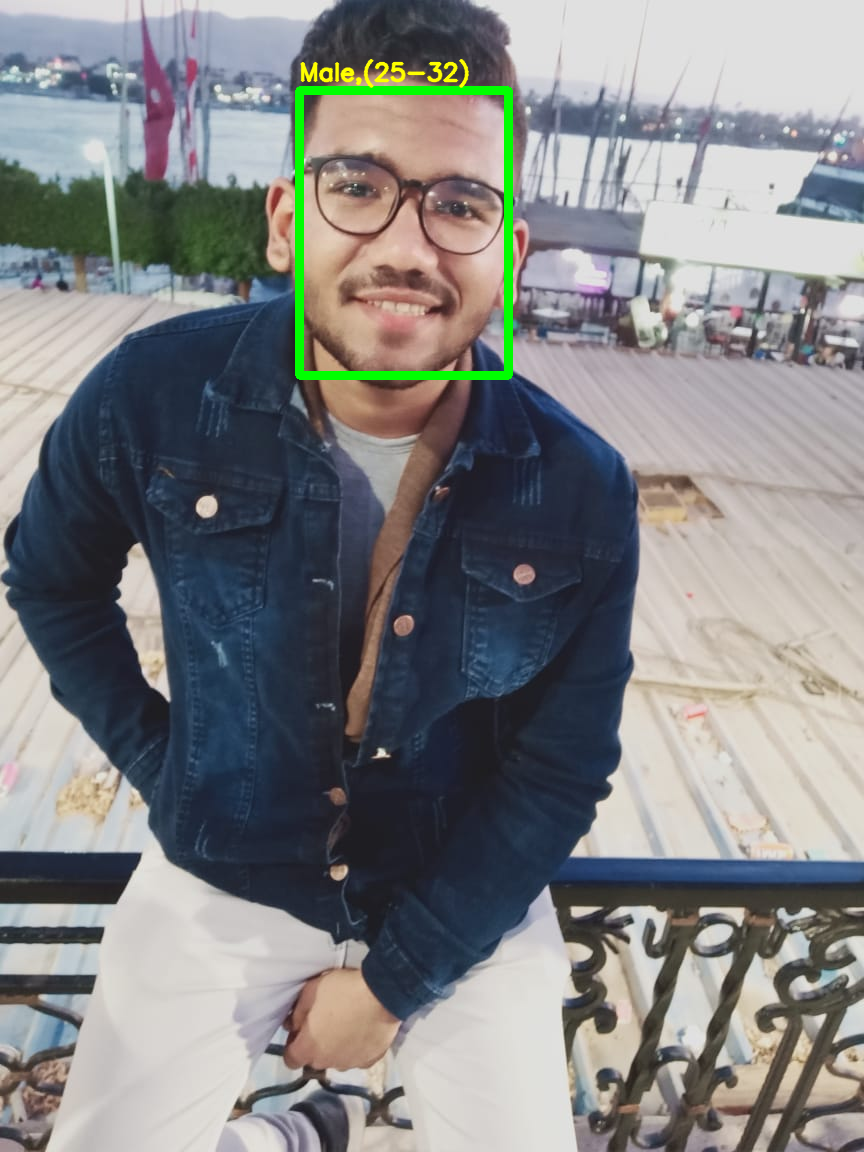

Gender : Male, conf = 1.000
Age Output : [[4.3730390e-05 1.0745721e-04 9.4681012e-04 1.7825741e-02 9.4578159e-01
  3.4682665e-02 4.6288600e-04 1.4902935e-04]]
Age : (25-32), conf = 0.946


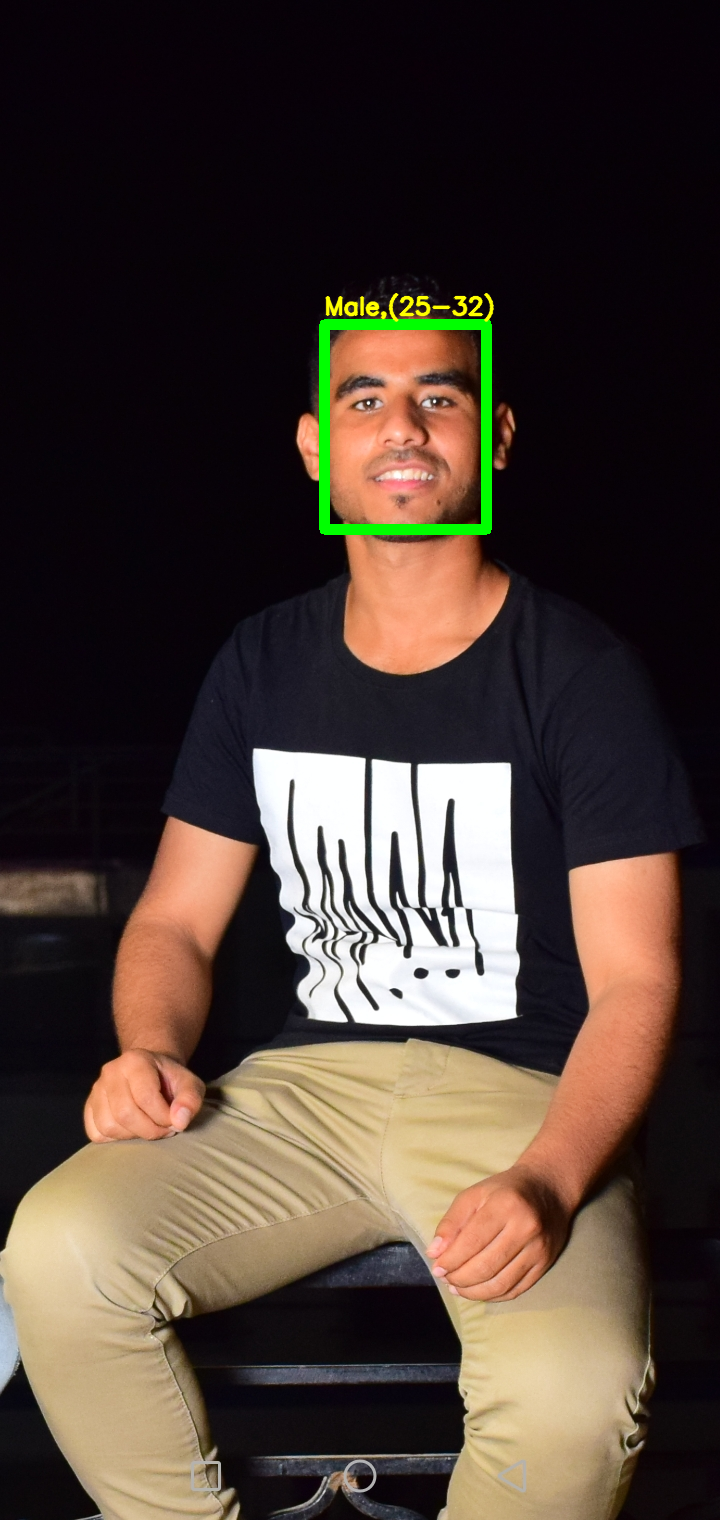

In [6]:
Read_Image("./Age_Estimation_proj/img/mamdoh.jpg")
Read_Image("./Age_Estimation_proj/img/mahmoud.jpg")